# Rock Physics inversion for water/CO2 saturation from Volcanic attenuation tomography data

In [1]:
import volcaniQ as vq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2
volcanic_data = vq.CleanReadCSV()
fluids = vq.FluidsReadCSV()
calibration = vq.RockPhysicsModelCalibrator()

## Fluids

First I have loaded some fluid data. I have taken the properties of CO<sub>2</sub> and water from the MNIST database based on their EOSs, the corresponding CSV file attached is created in Mathematica which relies on MNIST for thermodynamic data. The code in `FluidReadCSV` essentially loads these up i.e. reading the CSV from

         fluids = FluidReadCSV()

can then return dataframes for depth dependence of each fluid `fluids('Water')` or `fluids('CarbonDioxide')`.

***please check these plotted below are reasonable!!***

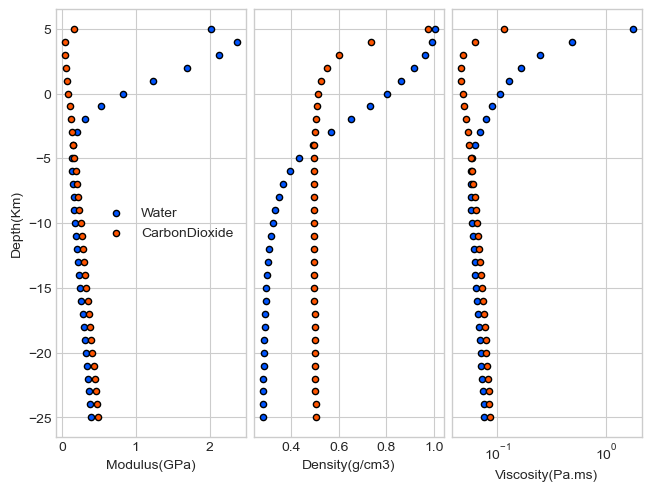

In [2]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(1, 3,constrained_layout = True)

fluid_names = {'Water':  '#0055FF', 'CarbonDioxide':'#FF5500'}
labels = {'Modulus(GPa)':'modulus', 'Density(g/cm3)':'density', 'Viscosity(Pa.ms)': 'viscosity'}

for lab, prop in enumerate(labels):
    for fluid in fluid_names:
        axs[lab].scatter(getattr(fluids(fluid),labels[prop]), -fluids(fluid).depth, c=fluid_names[fluid], s=20, edgecolors='black', label=fluid)
        axs[lab].set_xlabel(prop)

axs[0].legend()
axs[0].set_ylabel('Depth(Km)')

axs[1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

axs[2].set_xscale('log')
axs[2].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

These will need to be combined into an effective fluid for partial saturation. This is done via `EffectiveFluid` class as per below. The two things that affect the squirt flow model, is the effective fluid modulus and the log frequency, both plotted below. The parameter `q` controls how unifrom the saturation is.

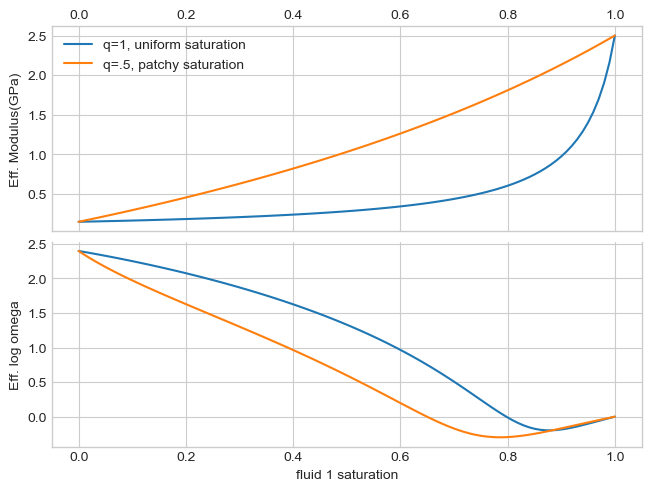

In [3]:
fl1 = vq.Fluid(density=1., viscosity=.5, modulus=2.5)
fl2 = vq.Fluid(density=.5, viscosity=.002, modulus=.15)
flmx = vq.EffectiveFluid(fl1, fl2)
sat = np.arange(0,1.01,.01)
def mod(q): return np.array([flmx(saturation=s, patch_parameter=q).modulus for s in sat])
def log_omega(q): return np.log10(np.array([flmx(saturation=s, patch_parameter=q).omega_c for s in sat]))
fig, ax = plt.subplots(2, 1,constrained_layout = True)
ax[0].plot(sat, mod(1), label='q=1, uniform saturation')
ax[0].plot(sat, mod(.1), label= 'q=.5, patchy saturation')
ax[0].legend()
ax[0].set_ylabel('Eff. Modulus(GPa)')
ax[1].plot(sat, log_omega(1), label='q=1, uniform saturation')
ax[1].plot(sat, log_omega(.1), label= 'q=.5, patchy saturation')
ax[1].set_ylabel('Eff. log omega')
ax[1].set_xlabel('fluid 1 saturation')
# ax[0].spines.bottom.set_visible(False)
ax[1].spines.top.set_visible(False)
ax[0].xaxis.tick_top()

ax[1].tick_params(labeltop=False)

## Model calibration

Now I need to calibrate the model, based on a fluid endpoint and the input parameters that we have. I have written a calibration class for this which is called in `RockPhysicsModelCalibrator()`. The way this works is more or less straightforward, call

        calibration = RockPhysicsModelCalibrator()
        model = calibration(Vp = vp, Vs = vs, Rho = rho, Qp=qp, phi=.15, Kf=kw)

and you get a rock physics model that will have the Qp, Vp, Vs values at a reference frequency, which I have taken to be the squirt flow frequency of water saturated rock. The assumption is that the matrix is quartz 

***does quarz make sense?***

With these assumptions, you can calibrate the model and check it returns the right values when `omegac` (the log squirt flow frequency of the model relative to water) is zero. Code below does that for some generic parameters and playing with them seems to work.

In [7]:
ref_vp, ref_vs, ref_rho, ref_qp = 5., 2.3, 2.7, 45
model = calibration(Vp = ref_vp, Vs = ref_vs, Rho = ref_rho, Qp=ref_qp, phi=.34, Kf=2.25)
cij_at_calibration = np.round(model(omegac=0., fluid_modulus=2.25).squirt_flow_model(0),2)
q = (lambda x: np.real(x)/np.imag(x))
tuple(model(omegac=0., fluid_modulus=2.25).squirt_flow_model(0)[[0,5],[0,5]]), (lambda x: np.real(x)/np.imag(x))(model(omegac=0, fluid_modulus=2.25).squirt_flow_model(0)[0,0])
{'calculated': {"p-modulus":cij_at_calibration[0,0], "s-modulus":cij_at_calibration[5,5], "qp":q(cij_at_calibration[0,0])}, 'observed':{"p-modulus":ref_vp**2*ref_rho, "s-modulus":ref_vs**2*ref_rho, "qp":ref_qp}}

{'calculated': {'p-modulus': (67.55+1.5j),
  's-modulus': (14.32+0.04j),
  'qp': 45.03333333333333},
 'observed': {'p-modulus': 67.5, 's-modulus': 14.283, 'qp': 45}}

## The data

There are a couple of crucial questions regarding the data.
 - is the calibration point rightly chosen where the white rectangle is? It seems to be relatively consistent down to about 5 km BSL, relative coordinates `x=17, y=-11`
 - are Qp and Qs derived at the same frequency? I have assumed so, but it is not clear and also the Qp/Qs that the model predicts at the same frequency is realatively constant but can vary wildly if the frequency of measurement of Qp and that of Qs vary by up to an order of magnitude. If that is so, there is some really exciting modelling to be done for the inversion. Actually, only need to know if the central frequency at which  the Qp and Qs were calculated might be different, if so, the difference can feed into a grid search.

In [4]:
import plotly.express as px
import plotly.graph_objects as go
xmin, xmax = 15, 18
ymin, ymax = -10, -12
fig = px.scatter(volcanic_data.data[volcanic_data.data['z'] ==-5], x='x', y='y',
              color='Qp')
fig.add_shape(type="rect",
    x0=xmin, y0=ymin, x1=xmax, y1=ymax,
    line=dict(color="White"),
    fillcolor="White",
    opacity=0.7,
)
fig.add_annotation(
            x=16., y=-9,
            text=f"Calibration(100% water)",
            showarrow=True,
            font=dict(
                family="sans-serif",
                size=12,
                color="#ffffff"
            ),
            arrowcolor="#ffffff",
            arrowhead=1)
fig.update_yaxes(
      scaleanchor="x",
      scaleratio=1,
)

fig.show()

## The model calibrated on the data

Noting all the above, I have calibrated the model on the basis that the white calibration square is water only and assume the rock physics model is to change every km of earth (since that's the resoultion of the data). I have taken into account the change of fluid properties as depth increases so the saturation should give a calibrated model at every depth. At the rock physics level, calibration is done for the values of K, mu and Qp that are in the data on the white square. I have assumed quartz all the way and constant porosity of 15%.

In [9]:
def calibration_model_by_depth(depth:int, xmin:int=15, xmax:int=18, ymin:int=-12, ymax:int=-10):
    # data = volcanic_data.data\
    # [
    # volcanic_data.data["z"].between(depth,depth)
    # ]
    result = volcanic_data.data\
    [
    volcanic_data.data["z"].between(depth,depth) &\
    volcanic_data.data["x"].between(xmin, xmax) &\
    volcanic_data.data["y"].between(ymin, ymax)
    ]\
    .groupby('z')\
    .mean()
    k, rho, mu, qp = tuple(result[['K','ρ', 'μ','Qp']].values[0])
    kw, rhow, etaw = tuple(fluids('Water').temp_df[fluids('Water').temp_df['Depth(Km)']==depth][['Modulus(GPa)', 'Density(g/cm3)', 'Viscosity(Pa.ms)']].values[0])
    kco2, rhoco2, etaco2 = tuple(fluids('CarbonDioxide').temp_df[fluids('CarbonDioxide').temp_df['Depth(Km)']==depth][['Modulus(GPa)', 'Density(g/cm3)', 'Viscosity(Pa.ms)']].values[0])
    water = vq.Fluid(density=rhow, viscosity=etaw, modulus=kw)
    co2 = vq.Fluid(density=rhoco2, viscosity=etaco2, modulus=kco2)
    watCo2mix = vq.EffectiveFluid(water, co2)
    watCo2mix.brooks_corey_lambda = 1.
    vp = np.sqrt((k + 4/3*mu)/rho)
    vs = np.sqrt(mu/rho)
    model = calibration(Vp = vp, Vs = vs, Rho = rho, Qp=qp, phi=.15, Kf=kw)
    def saturation_dependent_model(sw, q):
        mix = watCo2mix(saturation=sw, patch_parameter=q, reference_frequency=1)
        omega_c,fluid_modulus = np.log10(mix.omega_c), mix.modulus
        return model(omegac=omega_c, fluid_modulus=fluid_modulus)
    return saturation_dependent_model

I am faced with the problem of whether the (central) frequency content that was used to calculate Q is the same for the p and the s waves. If so, then the Qp/Qs ratio is more or less the same along saturations, but if they are different (which I think in earthquakes, they are) then I'd need to know by how much before I can invert the data for saturation. At this stage suffices to know if *assuming* they are different is reasonable.

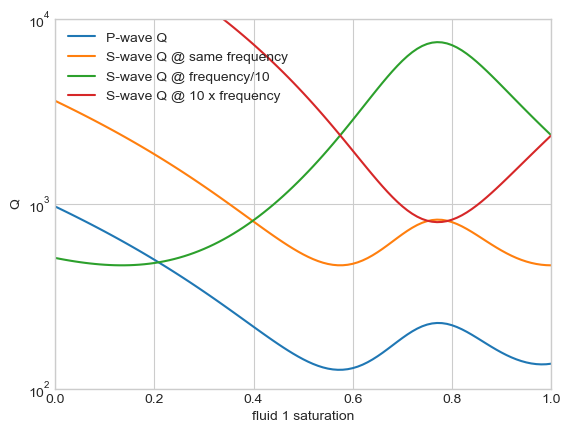

In [40]:
model3 = calibration_model_by_depth(depth = -5)
s = np.arange(0,1.01,0.01)
def forward_data(freq): return np.array([model3(s1, 1).squirt_flow_model(freq) for s1 in s])
q = (lambda x: np.real(x)/np.imag(x))

y = q(forward_data(0)[:,0,0])
y1 = q(forward_data(1)[:,5,5])
y2 = q(forward_data(0)[:,5,5])
y3 = q(forward_data(-1)[:,5,5])
fig, ax = plt.subplots()
ax.set_xlim(0,1)
ax.set_ylim(100, 10000)
ax.set_yscale('log')
ax.plot(s, y, label='P-wave Q')
ax.plot(s, y2, label='S-wave Q @ same frequency')
ax.plot(s, y1, label='S-wave Q @ frequency/10')
ax.plot(s, y3, label='S-wave Q @ 10 x frequency')
ax.set_ylabel('Q')
ax.set_xlabel('fluid 1 saturation')

ax.legend()



<AxesSubplot:xlabel='z'>

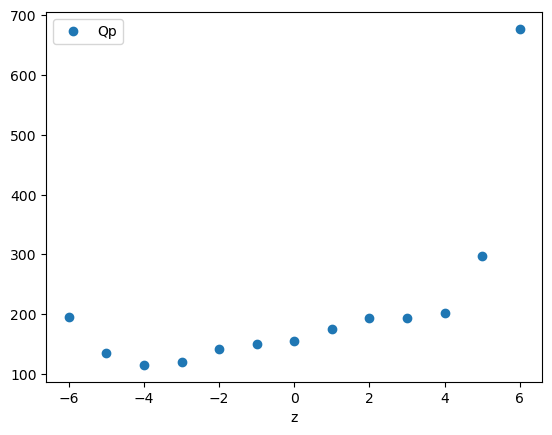

In [151]:
volcanic_data.data\
    [
    volcanic_data.data["z"].between(-6,6) &\
    volcanic_data.data["x"].between(xmin, xmax) &\
    volcanic_data.data["y"].between(ymin, ymax)
    ]\
    .groupby('z')\
    .mean()\
    .plot(y='Qp', style='o')